# CE6003 Etivity 3
* Name : Martin Power
* ID    : 9939245

# Kalman Filter - Lab 7.2 Exercise

## Recap
We have seen how the kalman filter can be applied for object tracking.
It is recommended that you complete this exercise and then review lab7_2 once your understanding is improved. 

In this exercise we will used the kalman filter to predict the track of a cannonball. We will using the same kalman filter code block from the the previous lab. but in this case we will setup the problem and intialise the required matrices ourseleves before passing them to the Kalman filter. The problem is straightfoward to set up and uses the same equations of motion as shown in the videos and notes. A very useful reference that summarises the equations and  that will help you compelete this excercise is 
http://greg.czerniak.info/guides/kalman1/

The purpose of this exercise is to improve your understanding of how the Kalman Filter works. 



In [60]:
import os
import re
import io
import cv2
import time
import base64
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display



**Define Noisy Model to Generate Measurements**

A simple model of a cannonball is used to generate noisy measurements that we can supply to the kalman filter. This replaces the object centres from the Lab_7_2. The measurements include a noisy measurement of position and another measurment (with a different noise level) for velocity. 

[]

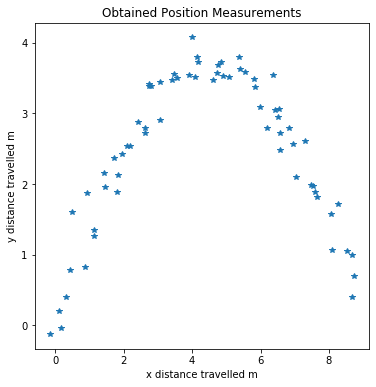

In [61]:
# Simple cannon ball model that generates a series of noise measurements at each time step.

dt  = 0.025 # Time step.
t_end = 1.72   # Final time
t_steps = int(t_end/dt) #Number of time steps required
v_o  = 10 # Intial velocity m/s
theta = 45 # Launch angle
g = 9.81   #Graviational acceleration m/s2
sigma = 0.2 # Position noise
sigma2 = 0.1 # Velocity nois

def cannonball_model(v_o):
   v_ox = v_o*math.cos(theta) # x direction starting velocity.
   v_oy = v_o*math.sin(theta) # y direction starting velocity.
   x0 = 0
   y0 = 0
   xpos = np.array([])
   v_x = np.array([])
   ypos = np.array([])
   v_y = np.array([])

   for steps in range(t_steps):
      t = steps*dt
      # Calculate x equations of motion in x direction
      x = x0 + v_ox*t + np.random.normal(0,sigma)
      xpos=np.append(xpos,x)  
      v_xt = v_ox + np.random.normal(0,sigma2)

      v_x = np.append(v_x,v_xt)
      # Calculate equations of motion in y direction
      y = y0 + v_oy*t-0.5*g*(t**2) + np.random.normal(0,sigma)
      v_yt = v_oy-g*t+np.random.normal(0,sigma2)
      ypos=np.append(ypos,y)  
      v_y = np.append(v_y,v_yt)

   return xpos,ypos,v_x,v_y
     
xpos,ypos,v_x,v_y=cannonball_model(v_o)

# Stitch these model outputs into one matrix of measurements z
z_all= np.concatenate((xpos,v_x,ypos,v_y)).reshape(4,len(xpos))

# Plot the trajectory with noise.
plt.figure(figsize=(6,6))
plt.plot(xpos, ypos, '*')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements')
plt.plot()

**Kalman Model**

In [62]:
def kalman(x, P, z, R, u, Q, A, B, H):
    '''
    Dynamic Parameters
    x: state
    P: state uncertainty covariance
    measurement: measurement
    R: measurement noise

    return:
        updated and predicted new values for (x, P)
    '''

    # Update Step
    # Update x and P based on measurement m
    # distance between measured and current position-belief
    y = np.matrix(z).T - H * x
   
    S = H * P * H.T + R
    K = P * H.T * S.I
    x = x + K * y
    I = np.matrix(np.eye(A.shape[0]))
    P = (I - K*H)*P

    # Predict Step
    # Predict x and P based on motion
    x = A*x + B*u
    P = A*P*A.T + Q

    return x, P


**Initialise Matrices**
Take a look at the section "Multi Variable" example in http://greg.czerniak.info/guides/kalman1/ to see how to initialise the required matrices.
Note 1: The matrices are entered using the numpy matrix command which allows a string of values to be converted to a numpy array E.g.

    my_matrix=np.matrix('''
        1. 0. 0. 0.;
        0. 1. 0. 0.;
        0. 0. 1. 0.;
        0. 0. 0. 1. 
        ''')

Some matrices my need to initialised as a column, a row can be converted to a column with a Transpose operation with np.matrix

my_other_matrix = np.matrix('0.0 0.0 0. 0.').T

Note 2: you need to place values rather than symbolic expressions into the matrix

In [81]:
def initialise_matrices():
    # Using matrices from examples at http://greg.czerniak.info/guides/kalman1/

    # Initialise matrix state transition matrix A and state control matrix B
    # - State Transition Matrix A
    A = np.matrix([[1, dt,  0,  0],
                   [0,  1,  0,  0],
                   [0,  0,  1, dt],
                   [0,  0,  0,  1]])

    # - Control Maxtrix B
    B = np.matrix([[0,  0,  0,  0],
                   [0,  0,  0,  0],
                   [0,  0,  1,  0],
                   [0,  0,  0,  1]])


    # Initialise state vector x (x_pos, x_v, y_pos, y_v)  (Is a column)
    x_pos_init, y_pos_init = 0,0
    x_v_init, y_v_init     = v_o*math.cos(theta), v_o*math.sin(theta)
    x = np.matrix([[x_pos_init, x_v_init, y_pos_init, y_v_init]]).T


    # Initialise the control matrix u (Is a column)
    u = np.matrix([[0, 0, -0.5*g*dt*dt, -1.0*g*dt]]).T    


    # Initialise prediction covariance matrix P
    # Value of 100 recommended by Emdalo Notebook
    P_scale  = 100 
    P = np.matrix(np.eye(4))*P_scale

    # Setup observation matrix H (This links state vectors to measurement)
    H = np.matrix(np.eye(4))

    # Set process noise covariance matrix Q 
    # Value of 1 recommended by Emdalo Notebook but
    # this gave a very jagged result (possibly too big 
    # a value relative to sigma/sigma2)
    # Instead setting to zero
    Q_scale = 0.0
    Q = np.matrix(np.eye(4))*Q_scale

    # Set measurement noise covariance matrix R
    # sigma is the position noise
    # sigma2 is the velocity noise
    #R = np.matrix(np.eye(4))*sigma <=== Delete
    R = np.matrix([[sigma, 0,      0,     0],
                   [0,     sigma2, 0,     0],
                   [0,     0,      sigma, 0],
                   [0,     0,      0,     sigma2]])

    
    return(A,B,x,u,P,Q,R,H) 


**Run Kalman Filter**
The measurements obtained from the simple cannonball model as supplied to the model along with initialised values from the previous cell.



68


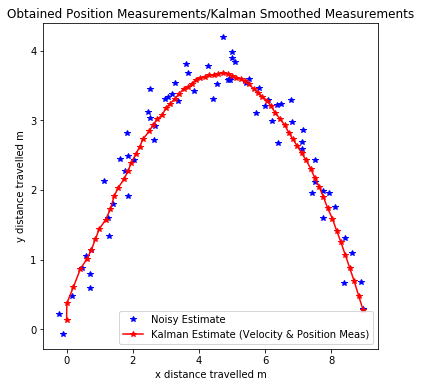

In [82]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices()

# Create arrays to store kalman estimates
xpos_est = np.array([])
v_x_est = np.array([])
ypos_est = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   z = z_all[:,i]

   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est=np.append(xpos_est,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est=np.append(ypos_est,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(6,6))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Estimate')
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements')
plt.legend()
plt.show()


**Part 2: Demonstrate advantages of Kalman filter.**
A major advantage of the Kalman filter is the abilty to obtain the model state from a limited set of measurements. In this section we will determine the cannonball position from the noisy velocity measurements only.

In two code cells below replicate the code for initialise_matrices() and also that code to run the Kalman filter. In this case the code (Hint: matrix H and measurements vector z) are to be modified such that only the velocity measurements are applied to the model. As in the previous case the output should show the smooth track of the cannonball. 

In [65]:
def initialise_matrices2():
    # Using matrices from examples at http://greg.czerniak.info/guides/kalman1/

    # Initialise matrix state transition matrix A and state control matrix B
    # - State Transition Matrix A
    A = np.matrix([[1, dt,  0,  0],
                   [0,  1,  0,  0],
                   [0,  0,  1, dt],
                   [0,  0,  0,  1]])

    # - Control Maxtrix B
    B = np.matrix([[0,  0,  0,  0],
                   [0,  0,  0,  0],
                   [0,  0,  1,  0],
                   [0,  0,  0,  1]])


    # Initialise state vector x (x_pos, x_v, y_pos, y_v)  (Is a column)
    x_pos_init, y_pos_init = 0,0
    x_v_init, y_v_init     = v_o*math.cos(theta), v_o*math.sin(theta)
    x = np.matrix([[x_pos_init, x_v_init, y_pos_init, y_v_init]]).T


    # Initialise the control matrix u (Is a column)
    u = np.matrix([[0, 0, -0.5*g*dt*dt, -1.0*g*dt]]).T    


    # Initialise prediction covariance matrix P
    # Value of 100 recommended by Emdalo Notebook
    P_scale  = 100 
    P = np.matrix(np.eye(4))*P_scale

    # Setup observation matrix H (This links state vectors to measurement)
    # H = np.matrix(np.eye(4))
    # Set the entries corresponding to position in the state vector to 0
    H = np.matrix([[0,  0,  0,  0],
                   [0,  1,  0,  0],
                   [0,  0,  0,  0],
                   [0,  0,  0,  1]])

    # Set process noise covariance matrix Q 
    # Value of 1 recommended by Emdalo Notebook but
    # this gave a very jagged result (possibly too big 
    # a value relative to sigma/sigma2)
    # Instead setting to zero
    Q_scale = 0.0
    Q = np.matrix(np.eye(4))*Q_scale

    # Set measurement noise covariance matrix R
    # sigma is the position noise
    # sigma2 is the velocity noise
    #R = np.matrix(np.eye(4))*sigma <=== Delete
    R = np.matrix([[sigma, 0,      0,     0],
                   [0,     sigma2, 0,     0],
                   [0,     0,      sigma, 0],
                   [0,     0,      0,     sigma2]])

    
    return(A,B,x,u,P,Q,R,H) 


68


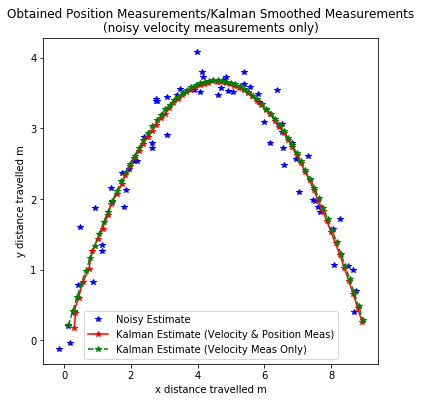

In [66]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices2()

# Create arrays to store kalman estimates
xpos_est2 = np.array([])
v_x_est = np.array([])
ypos_est2 = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   # Set the entries corresponding to position in the z to 0
   z_tmp = z_all[:,i]
   z = np.matrix([0, z_tmp[1], 0, z_tmp[3]])
   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est2=np.append(xpos_est2,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est2=np.append(ypos_est2,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(6,6))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Estimate')
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
# Plot kalman smoothed estimate ((Velocity Measurements Only))
plt.plot(xpos_est2, ypos_est2,'g*--', label='Kalman Estimate (Velocity Meas Only)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements\n(noisy velocity measurements only)')
plt.legend()
plt.show()


# Additiona Model with Increased Position Noise (Sigma = 0.8)

[]

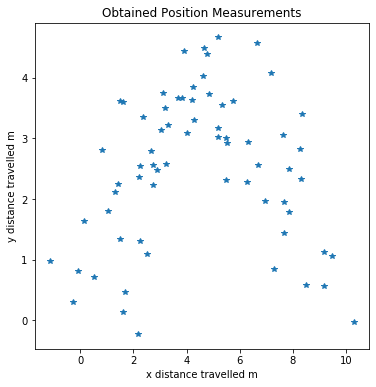

In [67]:
# Simple cannon ball model that generates a series of noise measurements at each time step.

dt  = 0.025 # Time step.
t_end = 1.72   # Final time
t_steps = int(t_end/dt) #Number of time steps required
v_o  = 10 # Intial velocity m/s
theta = 45 # Launch angle
g = 9.81   #Graviational acceleration m/s2
sigma = 0.8 # Position noise increased from 0.2 to 0.8
sigma2 = 0.1 # Velocity nois

def cannonball_model(v_o):
   v_ox = v_o*math.cos(theta) # x direction starting velocity.
   v_oy = v_o*math.sin(theta) # y direction starting velocity.
   x0 = 0
   y0 = 0
   xpos = np.array([])
   v_x = np.array([])
   ypos = np.array([])
   v_y = np.array([])

   for steps in range(t_steps):
      t = steps*dt
      # Calculate x equations of motion in x direction
      x = x0 + v_ox*t + np.random.normal(0,sigma)
      xpos=np.append(xpos,x)  
      v_xt = v_ox + np.random.normal(0,sigma2)

      v_x = np.append(v_x,v_xt)
      # Calculate equations of motion in y direction
      y = y0 + v_oy*t-0.5*g*(t**2) + np.random.normal(0,sigma)
      v_yt = v_oy-g*t+np.random.normal(0,sigma2)
      ypos=np.append(ypos,y)  
      v_y = np.append(v_y,v_yt)

   return xpos,ypos,v_x,v_y
     
xpos,ypos,v_x,v_y=cannonball_model(v_o)

# Stitch these model outputs into one matrix of measurements z
z_all= np.concatenate((xpos,v_x,ypos,v_y)).reshape(4,len(xpos))

# Plot the trajectory with noise.
plt.figure(figsize=(6,6))
plt.plot(xpos, ypos, '*')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements')
plt.plot()

## Use Velocity  and Position Measurements

68


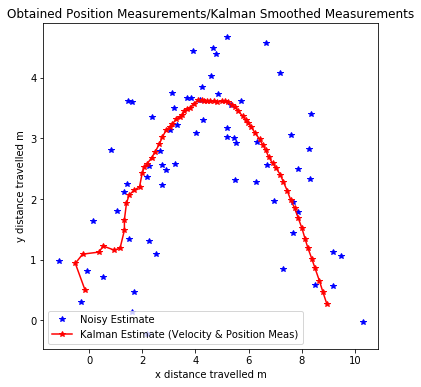

In [68]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices()

# Create arrays to store kalman estimates
xpos_est = np.array([])
v_x_est = np.array([])
ypos_est = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   z = z_all[:,i]

   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est=np.append(xpos_est,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est=np.append(ypos_est,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(6,6))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Estimate')
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements')
plt.legend()
plt.show()


## Use Velocity Measurements Only

68


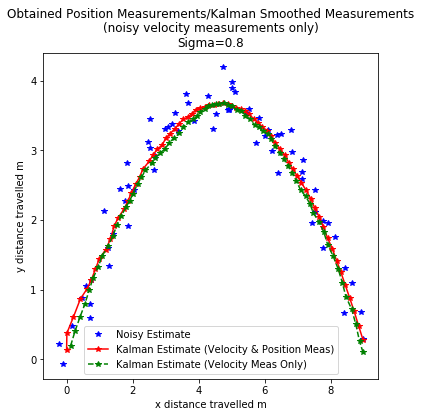

In [83]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices2()

# Create arrays to store kalman estimates
xpos_est2 = np.array([])
v_x_est = np.array([])
ypos_est2 = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   # Set the entries corresponding to position in the z to 0
   z_tmp = z_all[:,i]
   z = np.matrix([0, z_tmp[1], 0, z_tmp[3]])
   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est2=np.append(xpos_est2,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est2=np.append(ypos_est2,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(6,6))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Estimate')
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
# Plot kalman smoothed estimate ((Velocity Measurements Only))
plt.plot(xpos_est2, ypos_est2,'g*--', label='Kalman Estimate (Velocity Meas Only)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements\n(noisy velocity measurements only)\nSigma=0.8')
plt.legend()
plt.show()


# Additiona Model with Increased Velocity Noise (Sigma2 = 0.8)

[]

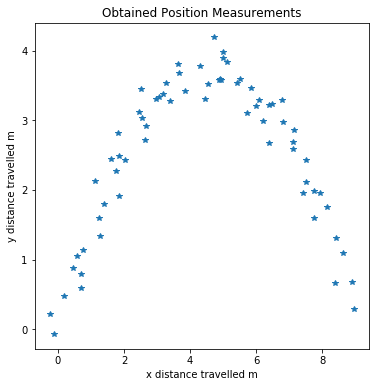

In [76]:
# Simple cannon ball model that generates a series of noise measurements at each time step.

dt  = 0.025 # Time step.
t_end = 1.72   # Final time
t_steps = int(t_end/dt) #Number of time steps required
v_o  = 10 # Intial velocity m/s
theta = 45 # Launch angle
g = 9.81   #Graviational acceleration m/s2
sigma = 0.2 # Position noise
sigma2 = 0.8 # Velocity noise increased from 0.1 to 0.8

def cannonball_model(v_o):
   v_ox = v_o*math.cos(theta) # x direction starting velocity.
   v_oy = v_o*math.sin(theta) # y direction starting velocity.
   x0 = 0
   y0 = 0
   xpos = np.array([])
   v_x = np.array([])
   ypos = np.array([])
   v_y = np.array([])

   for steps in range(t_steps):
      t = steps*dt
      # Calculate x equations of motion in x direction
      x = x0 + v_ox*t + np.random.normal(0,sigma)
      xpos=np.append(xpos,x)  
      v_xt = v_ox + np.random.normal(0,sigma2)

      v_x = np.append(v_x,v_xt)
      # Calculate equations of motion in y direction
      y = y0 + v_oy*t-0.5*g*(t**2) + np.random.normal(0,sigma)
      v_yt = v_oy-g*t+np.random.normal(0,sigma2)
      ypos=np.append(ypos,y)  
      v_y = np.append(v_y,v_yt)

   return xpos,ypos,v_x,v_y
     
xpos,ypos,v_x,v_y=cannonball_model(v_o)

# Stitch these model outputs into one matrix of measurements z
z_all= np.concatenate((xpos,v_x,ypos,v_y)).reshape(4,len(xpos))

# Plot the trajectory with noise.
plt.figure(figsize=(6,6))
plt.plot(xpos, ypos, '*')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements')
plt.plot()

## Use Velocity  and Position Measurements

68


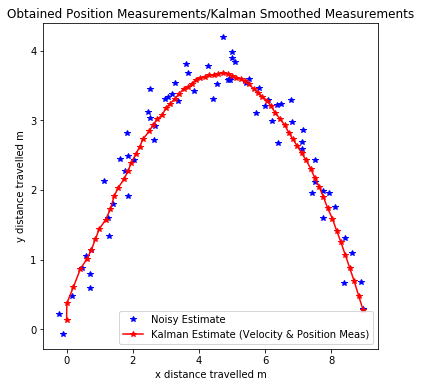

In [77]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices()

# Create arrays to store kalman estimates
xpos_est = np.array([])
v_x_est = np.array([])
ypos_est = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   z = z_all[:,i]

   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est=np.append(xpos_est,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est=np.append(ypos_est,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(6,6))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Estimate')
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements')
plt.legend()
plt.show()


## Use Velocity Measurements Only

68


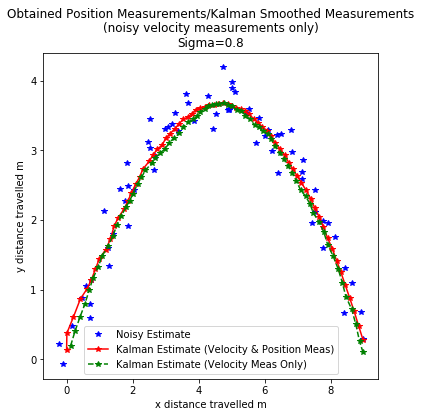

In [84]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices2()

# Create arrays to store kalman estimates
xpos_est2 = np.array([])
v_x_est = np.array([])
ypos_est2 = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   # Set the entries corresponding to position in the z to 0
   z_tmp = z_all[:,i]
   z = np.matrix([0, z_tmp[1], 0, z_tmp[3]])
   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est2=np.append(xpos_est2,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est2=np.append(ypos_est2,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(6,6))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Estimate')
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
# Plot kalman smoothed estimate ((Velocity Measurements Only))
plt.plot(xpos_est2, ypos_est2,'g*--', label='Kalman Estimate (Velocity Meas Only)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements\n(noisy velocity measurements only)\nSigma=0.8')
plt.legend()
plt.show()
